In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from glob import glob
from datetime import datetime
from IPython.display import display
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline 

In [3]:
arquivos = glob("C:/Users/ppgar/OneDrive/Documentos/Dados/Treino/*.csv")
df = pd.DataFrame([])
for arquivo in arquivos:
    dados = pd.read_csv(arquivo, sep = ";")
    df = pd.concat([df, dados])
treino = df

In [4]:

treino['din_instante'] = pd.to_datetime(treino['din_instante'])
treino['din_instante'] = treino['din_instante'].dt.strftime('%Y-%m')
treino = treino.rename(columns = {'din_instante': 'data'})
print(type(treino['data']))


<class 'pandas.core.series.Series'>


In [5]:
print(type(treino['data']))

<class 'pandas.core.series.Series'>


In [6]:
display(pd.unique(treino['id_subsistema']))

array(['N', 'NE', 'S', 'SE'], dtype=object)

In [7]:
treino = treino.drop(['nom_subsistema', 'nom_estado', 'ceg', 'id_ons', 'nom_tipousina', 'nom_usina', 'id_estado', 'cod_modalidadeoperacao'], axis = 1)




In [8]:
display(treino.groupby('id_subsistema').sum())

,val_geracao
id_subsistema,
N,8.132515e+08
NE,1.092222e+09
S,1.383696e+09
SE,5.336470e+09


In [9]:
norte = treino[treino['id_subsistema'] == "N"]
nordeste = treino[treino['id_subsistema'] == "NE"]
sul = treino[treino['id_subsistema'] == "S"]
sudeste = treino[treino['id_subsistema'] == "SE"]

In [10]:
display(treino)

,data,id_subsistema,nom_tipocombustivel,val_geracao
0,2000-01,N,Hidráulica,2422.500
1,2000-01,NE,Hidráulica,1995.600
2,2000-01,NE,Hidráulica,13.000
3,2000-01,NE,Hidráulica,202.500
4,2000-01,NE,Hidráulica,269.800
...,...,...,...,...
4288651,2018-12,SE,Biomassa,21.000
4288652,2018-12,SE,Biomassa,13.000
4288653,2018-12,SE,Hidráulica,119.600
4288654,2018-12,SE,Hidráulica,476.403


In [11]:
norte = norte.groupby('data').sum('val_geracao')
sul = sul.groupby('data').sum('val_geracao')
sudeste = sudeste.groupby('data').sum('val_geracao')
nordeste = nordeste.groupby('data').sum('val_geracao')


In [12]:
display(norte)

,val_geracao
data,
2000-01,2459950.900
2000-02,2196414.200
2000-03,2261361.100
2000-04,2264178.200
2000-05,2430484.600
...,...
2018-08,5573038.178
2018-09,5048504.188
2018-10,4826781.938


In [13]:
model = auto_arima(norte, seasonal=True, m=12)

In [14]:
model.fit(norte)

ARIMA(order=(5, 1, 4), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

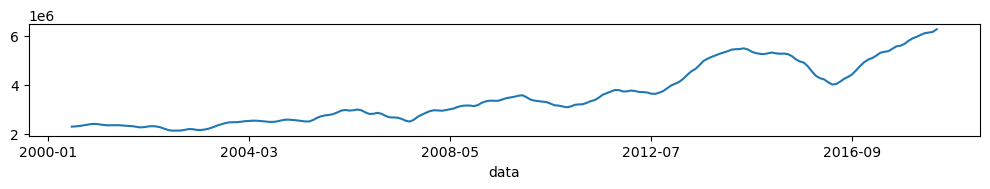

In [15]:
decomposition = seasonal_decompose(norte, model='multiplicative', period=12)  # decomposição anual
#fig = decomposition.plot()
plt.figure(figsize = [10, 2])
decomposition.trend.plot()
plt.tight_layout()
plt.show()

In [16]:
arquivos = glob("C:/Users/ppgar/OneDrive/Documentos/Dados/Validacao/*.csv")
df = pd.DataFrame([])
for arquivo in arquivos:
    dados = pd.read_csv(arquivo, sep = ";")
    df = pd.concat([df, dados])
validacao = df


In [17]:
validacao['din_instante'] = pd.to_datetime(validacao['din_instante'])
validacao['din_instante'] = validacao['din_instante'].dt.strftime('%Y-%m')
validacao = validacao.rename(columns = {'din_instante': 'data'})


In [18]:
Vnorte = validacao[validacao['id_subsistema'] == "N"]
Vnordeste = validacao[validacao['id_subsistema'] == "NE"]
Vsul = validacao[validacao['id_subsistema'] == "S"]
Vsudeste = validacao[validacao['id_subsistema'] == "SE"]
Vnorte = Vnorte.groupby('data').sum('val_geracao')
Vsul = Vsul.groupby('data').sum('val_geracao')
Vsudeste = Vsudeste.groupby('data').sum('val_geracao')
Vnordeste = Vnordeste.groupby('data').sum('val_geracao')

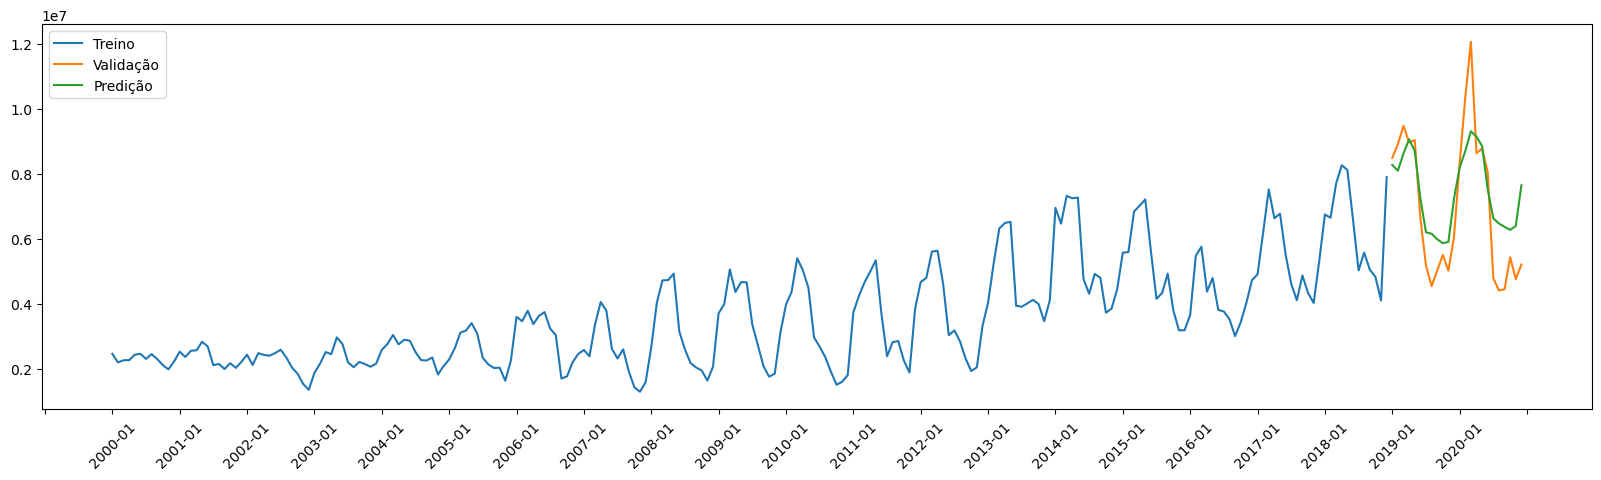

In [19]:
forecast = model.predict(n_periods=len(Vnorte))
forecast = pd.DataFrame(forecast,index = Vnorte.index,columns=['Prediction'])

#plot the predictions for validation set
plt.figure(figsize = (20,5))
plt.plot(norte, label='Treino')
plt.plot(Vnorte, label='Validação')
plt.plot(forecast, label='Predição')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)

plt.show()

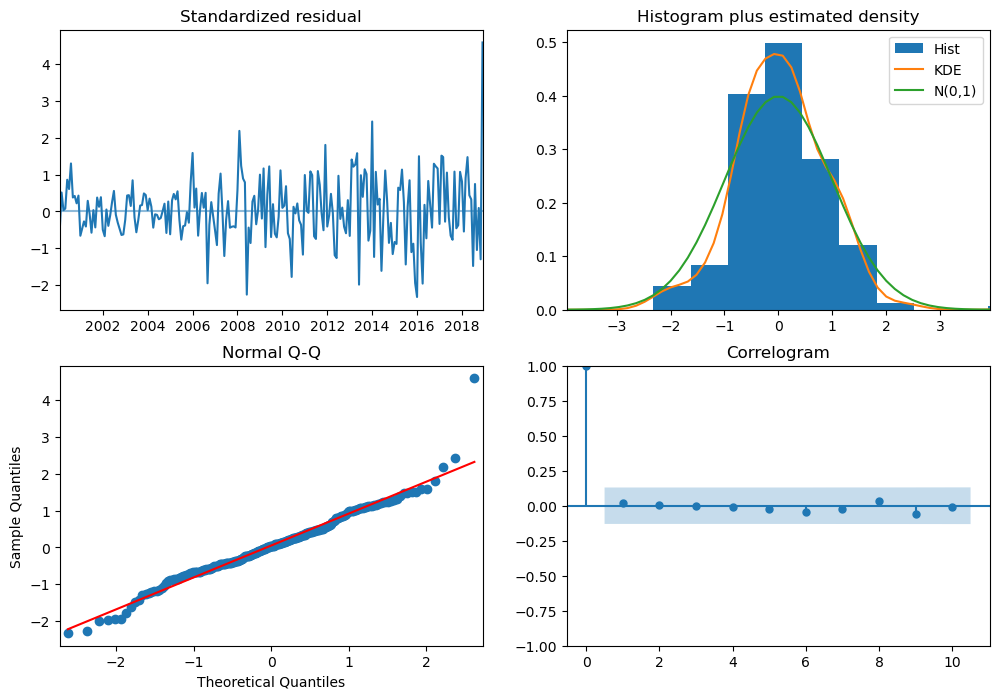

In [20]:
model.plot_diagnostics(figsize=(12, 8))
plt.show()

In [21]:
print(norte)

         val_geracao
data                
2000-01  2459950.900
2000-02  2196414.200
2000-03  2261361.100
2000-04  2264178.200
2000-05  2430484.600
...              ...
2018-08  5573038.178
2018-09  5048504.188
2018-10  4826781.938
2018-11  4099335.748
2018-12  7895074.397

[228 rows x 1 columns]
